In [1]:
from typing import Tuple, List, Optional
import os
import glob
from functools import partial

import einops
import dask
from dask.distributed import Client, LocalCluster
import numpy as np
import xarray as xr
import torch
from torch.utils.data import Dataset, DataLoader

from graph_weather.data.wb_dataset import WeatherBenchDataset, worker_init_func
from graph_weather.data.wb_constants import WeatherBenchConstantFields
from graph_weather.data.wb_datamodule import _custom_collator_wrapper
from graph_weather.utils.config import YAMLConfig
from graph_weather.utils.logger import get_logger

/perm/syma/conda-envs/shared/dev-gnn-gpu/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cf

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
LOGGER = get_logger(__name__)

In [4]:
config_file = "/home/syma/dask/codes/graph_weather/graph_weather/config/wb_config_atos.yaml"
config = YAMLConfig(config_file)

In [5]:
def _load_summary_statistics() -> Tuple[np.ndarray, np.ndarray]:
        # load pre-computed means and standard deviations
        var_names = config["input:variables:names"]
        var_means = xr.load_dataset(
            os.path.join(
                config["input:variables:training:basedir"], config["input:variables:training:summary-stats:means"]
            )
        )
        var_sds = xr.load_dataset(
            os.path.join(
                config["input:variables:training:basedir"], config["input:variables:training:summary-stats:std-devs"]
            )
        )
        return var_means[var_names], var_sds[var_names]

In [6]:
var_means, var_sds = _load_summary_statistics()

In [7]:
var_means

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float32 7.776e+04
    t        float32 243.0
    q        float32 0.001763
    w        float32 0.004084
    u        float32 7.214
    v        float32 0.02791

In [8]:
var_sds

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float32 1.48e+03
    t        float32 5.403
    q        float32 0.0007088
    w        float32 0.09496
    u        float32 9.359
    v        float32 8.033

In [9]:
def get_weatherbench_dataset(
    fnames: List[str],
    varnames: List[str],
    plevs: Optional[List[int]],
    client: Client,
    config: YAMLConfig,
) -> xr.Dataset:
    LOGGER.debug("Created Dask client %s attached to %s ...", client, client.scheduler_info)
    kwargs = dict(consolidated=True) if config["input:format"] == "zarr" else {}
    sel_plevs = plevs if plevs is not None else slice(None)
    return xr.open_mfdataset(
        fnames,
        parallel=(client is not None),  # uses Dask if a client is present
        chunks={"time": 1},
        engine=config["input:format"],
        **kwargs,
    )[varnames].sel(level=sel_plevs)

In [10]:
ds_test = WeatherBenchDataset(
    fnames=glob.glob(
        os.path.join(config["input:variables:test:basedir"], config["input:variables:test:filename-template"])
    ),
    var_names=config["input:variables:names"],
    read_wb_data_func=partial(get_weatherbench_dataset, config=config),
    var_mean=var_means,
    var_sd=var_sds,
    plevs=config["input:variables:levels"],
    lead_time=config["model:lead-time"],
    batch_chunk_size=config["model:dataloader:batch-chunk-size:inference"],
    rollout=config["model:rollout"],
)

In [11]:
bs = config["model:dataloader:batch-size:inference"]
bcs = config["model:dataloader:batch-chunk-size:inference"]
num_workers = config["model:dataloader:num-workers:inference"]

In [12]:
def _get_dataloader(data: xr.Dataset) -> DataLoader:
    return DataLoader(
            data,
            batch_size=bs,
            num_workers=num_workers,
            pin_memory=True,
            collate_fn=_custom_collator_wrapper(const_data.get_constants(bcs)),
            worker_init_fn=partial(
                worker_init_func,
                dask_temp_dir=os.path.join(config["output:basedir"], config["model:dask:temp-dir"]),
                num_dask_workers=config["model:dask:num-workers"],
                num_dask_threads_per_worker=config["model:dask:num-threads-per-worker"],
            ),
            prefetch_factor=2,
            persistent_workers=True,
    )

In [13]:
def test_dataloader() -> DataLoader:
    return _get_dataloader(ds_test)

In [14]:
const_data = WeatherBenchConstantFields(
    const_fname=config["input:constants:filename"],
    const_names=config["input:constants:names"],
)

In [15]:
dl_test = test_dataloader()

In [16]:
for batch in dl_test:
    print(type(batch))
    break

[2022-09-14T16:07:37Z] [wb_dataset.py:94 - per_worker_init] [DEBUG] Pytorch worker 0 creating Dask cluster, client and opening WB data files ...
[2022-09-14T16:07:37Z] [1917891926.py:8 - get_weatherbench_dataset] [DEBUG] Created Dask client <Client: 'inproc://10.100.192.104/676096/1' processes=8 threads=8, memory=119.21 GiB> attached to <bound method Client.scheduler_info of <Client: 'inproc://10.100.192.104/676096/1' processes=8 threads=8, memory=119.21 GiB>> ...
<class 'graph_weather.data.wb_datamodule.WeatherBenchDataBatch'>


In [17]:
assert len(batch.X) == config["model:rollout"] + 1

In [18]:
num_features = ds_test.nvar * ds_test.nlev
num_static = batch.X[0].shape[-1] - num_features
print(f"static features: {num_static}, physical features: {num_features}")

static features: 6, physical features: 78


In [19]:
batch.X[0].shape

torch.Size([1, 65160, 84])

In [20]:
batch.idx

tensor([[274],
        [275],
        [276],
        [277],
        [278]], dtype=torch.int32)

In [21]:
# open the dataset manually, get the samples at these indices
# compare against the contents of the batch object

cluster = LocalCluster(n_workers=4, threads_per_worker=1, processes=False)
client = Client(cluster)

ds_test_reference = xr.open_mfdataset(
    glob.glob(
        os.path.join(config["input:variables:test:basedir"], config["input:variables:test:filename-template"])
    ),
    chunks={"time": 1},
    parallel=True
)
ds_test_reference

/perm/syma/conda-envs/shared/dev-gnn-gpu/lib/python3.8/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44135 instead
  warnings.warn(


,Array,Chunk
Bytes,9.23 GiB,3.23 MiB
Shape,"(2924, 13, 181, 360)","(1, 13, 181, 360)"
Count,5 Graph Layers,2924 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,9.23 GiB,3.23 MiB
Shape,"(2924, 13, 181, 360)","(1, 13, 181, 360)"
Count,5 Graph Layers,2924 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [22]:
ds_test_samples = ds_test_reference.isel(time=batch.idx.flatten()).compute()
ds_test_samples

<xarray.Dataset>
Dimensions:    (longitude: 360, latitude: 181, level: 13, time: 5)
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * level      (level) int32 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * time       (time) datetime64[ns] 2020-03-09T12:00:00 ... 2020-03-10T12:00:00
Data variables:
    z          (time, level, latitude, longitude) float32 1.821e+05 ... -145.7
    t          (time, level, latitude, longitude) float32 193.2 193.2 ... 250.2
    q          (time, level, latitude, longitude) float32 3.046e-06 ... 5.142...
    w          (time, level, latitude, longitude) float32 -0.004395 ... -0.02058
    u          (time, level, latitude, longitude) float32 15.08 15.08 ... -2.345
    v          (time, level, latitude, longitude) float32 -5.47 -5.47 ... 0.4013
Attributes:
    Conventions:  CF-1.6
    history:      2022-06-25 00:40:03 GMT by grib_to_netcdf-2.23.0: grib_to_n...

In [23]:
ds_test_samples.time

<xarray.DataArray 'time' (time: 5)>
array(['2020-03-09T12:00:00.000000000', '2020-03-09T18:00:00.000000000',
       '2020-03-10T00:00:00.000000000', '2020-03-10T06:00:00.000000000',
       '2020-03-10T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-03-09T12:00:00 ... 2020-03-10T12:00:00
Attributes:
    long_name:  time

In [24]:
from typing import Optional

def plot_2d_field(data: np.ndarray, cmap: str = "viridis", cbar: bool = True, title: Optional[str] = None) -> None:
    assert len(data.shape) == 2, f"Need a 2D field to plot! Shape of data array: {data.shape}"
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))
    im = ax.imshow(data, aspect="auto", cmap=cmap)
    if cbar:
        # add space for colour bar
        fig.subplots_adjust(right=0.85)
        cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
        fig.colorbar(im, cax=cbar_ax)
        if title is not None:
            ax.set_title(title)
    plt.show()

### Visualize the reference dataset and the batched values + check if there are any differences

In [25]:
def build_batch_and_ref_dataset(batch: Tuple[torch.Tensor], reference: xr.Dataset) -> xr.Dataset:
    """builds an xr.Dataset with the batched and reference data. this can be used to compare the values (should be identical up to numerical roundoff)"""
    # stack all the batched samples
    assert batch[0].shape[0] == 1, "This works only with single-sample batches!"
    batch = np.stack(
        [x.numpy() for x in batch],
        axis=-1,
    ).squeeze()
    
    nlat, nlon = 181, 360
    # unpack to original shape
    batch = einops.rearrange(batch[:, :num_features, :], "(h w) (v l) r -> r v l h w", h=nlat, w=nlon, v=ds_test.nvar, l=ds_test.nlev)
    
    batched_varnames = config["input:variables:names"]

    for ivar, var in enumerate(batched_varnames):
        batch_t = batch[:, ivar, ...].squeeze() * var_sds[var].values + var_means[var].values
        reference[f"{var}_batched"] = xr.DataArray(
            data=batch_t,
            coords=reference.coords,
            dims=("time", "level", "latitude", "longitude"),
            attrs=reference[var].attrs
        )

    return reference

In [26]:
def compare_batch_against_reference(ds_batch_ref: xr.Dataset, i_batch: int) -> None:
    max_abs_diffs = {}
    min_max = {}
    for var in config["input:variables:names"]:
        min_max[var] = (ds_batch_ref[var].values.min(), ds_batch_ref[var].values.max())
        max_abs_diffs[var]= np.abs(ds_batch_ref[f"{var}_batched"].values - ds_batch_ref[var].values).max()
        for r in range(config["model:rollout"]):
            for l in range(len(ds_batch_ref.level)):
                var_ref = ds_batch_ref[var].isel(time=r, level=l)
                var_batched = ds_batch_ref[f"{var}_batched"].isel(time=r, level=l)
                var_diff = var_ref - var_batched
                if np.abs(var_diff).max() > 0.05 * var_sds[var]:
                    plot_2d_field(var_diff, cmap="bwr", title=f"rollout={r}, {var}_{ds_batch_ref.level[l]}")
                    plot_2d_field(var_ref, cmap="viridis", title=f"rollout={r}, {var}_{ds_batch_ref.level[l]}")
    print("*"*10, f" Batch {i_batch} ", "*"*10)
    print(f"Min/max reference: {[(k, v) for (k, v) in min_max.items()]}")
    print(f"Abs-diffs: {[(k, v) for (k, v) in max_abs_diffs.items()]}")

In [27]:
for i_batch, batch in enumerate(dl_test):
    # reference data
    ds_ref = ds_test_reference.isel(time=batch.idx.flatten()).compute()
    # batched data
    ds_batch_ref = build_batch_and_ref_dataset(batch.X, ds_ref)
    # compare batched against reference
    compare_batch_against_reference(ds_batch_ref, i_batch)
    # check just 10 (random) batches
    if i_batch >= 10:
        break

**********  Batch 0  **********
Min/max reference: [('z', (-4734.8086, 204021.56)), ('t', (184.39911, 315.023)), ('q', (-2.865334e-06, 0.022457825)), ('w', (-3.9010477, 4.79251)), ('u', (-50.236267, 102.337296)), ('v', (-66.25394, 93.99161))]
Abs-diffs: [('z', 0.00390625), ('t', 0.0), ('q', 1.8626451e-09), ('w', 2.3841858e-07), ('u', 7.6293945e-06), ('v', 7.6293945e-06)]
**********  Batch 1  **********
Min/max reference: [('z', (-3719.8313, 205798.56)), ('t', (185.96239, 323.90002)), ('q', (-1.7856524e-05, 0.026375238)), ('w', (-4.0134153, 2.949561)), ('u', (-33.079865, 84.88867)), ('v', (-73.4422, 57.921646))]
Abs-diffs: [('z', 0.00390625), ('t', 0.0), ('q', 1.8626451e-09), ('w', 2.3841858e-07), ('u', 7.6293945e-06), ('v', 3.8146973e-06)]
**********  Batch 2  **********
Min/max reference: [('z', (-3808.0188, 203696.25)), ('t', (184.85437, 317.3006)), ('q', (-1.2326477e-05, 0.022859309)), ('w', (-3.9775753, 2.3874712)), ('u', (-47.962143, 85.91092)), ('v', (-67.052704, 65.89877))]
Abs-

### Check the static fields

In [28]:
def check_static_fields(batch: Tuple[torch.Tensor]) -> None:
    assert batch[0].shape[0] == 1, "This works only with single-sample batches!"
    batch = np.stack(
        [x.numpy() for x in batch],
        axis=-1,
    ).squeeze()
    
    nlat, nlon = 181, 360
    # unpack to original shape - just the static fields (these come last)
    batch = einops.rearrange(batch[:, num_features:, :], "(h w) v r -> r v h w", h=nlat, w=nlon, v=num_static)
    print(batch.shape)
    # these are constants so first differences should be all zero
    batch_diff = np.diff(batch, n=1, axis=0)
    assert np.max(np.abs(batch_diff)) == 0.0
    for fidx in range(batch.shape[1]):
        plot_2d_field(batch[0, fidx, ...].squeeze())

(5, 6, 181, 360)


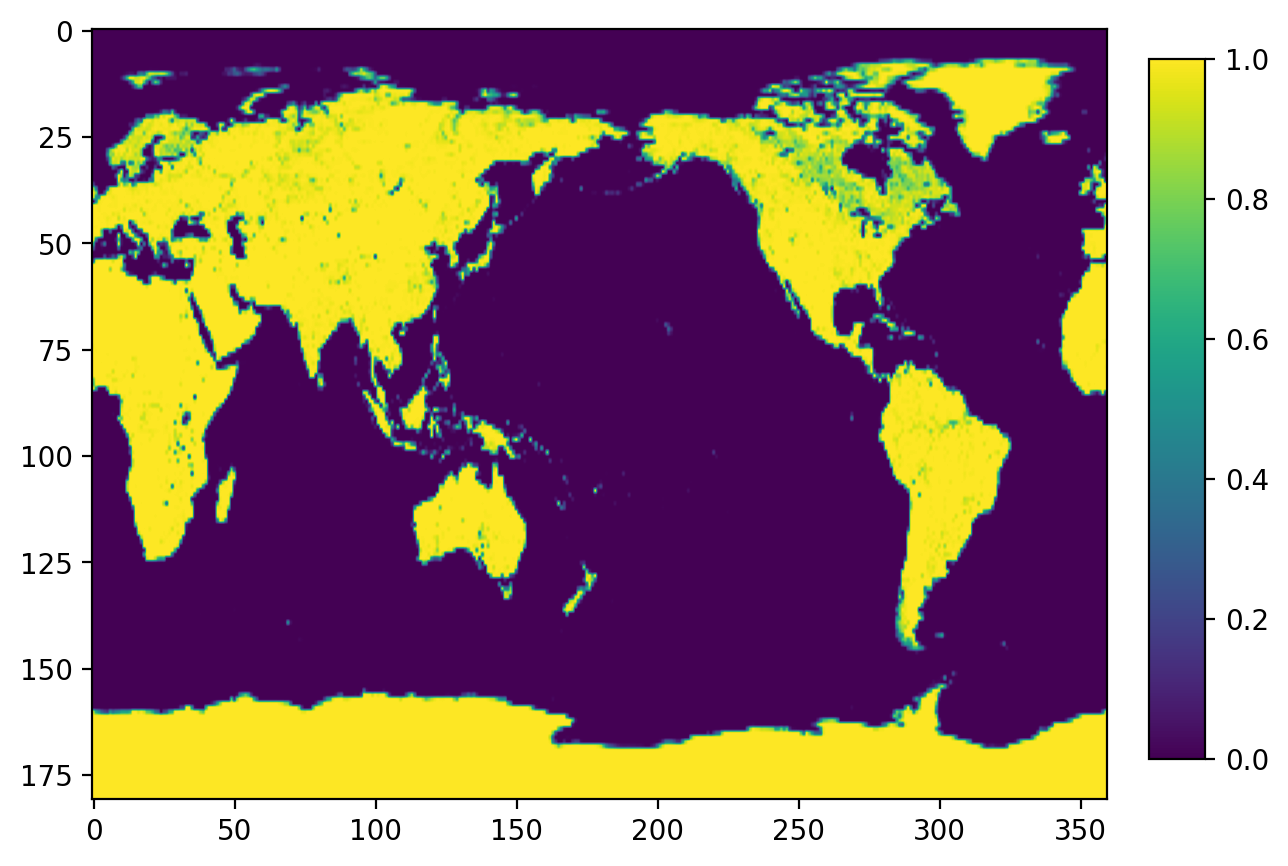

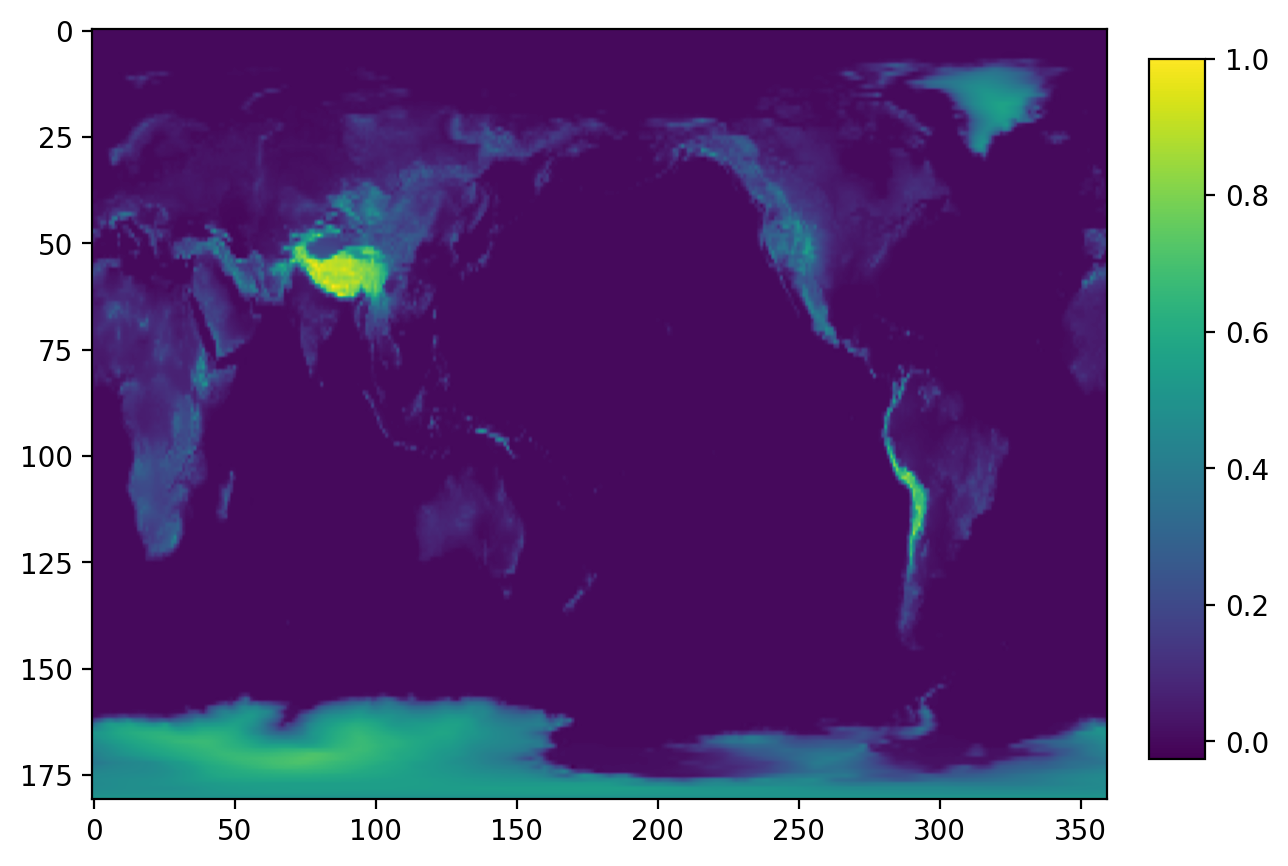

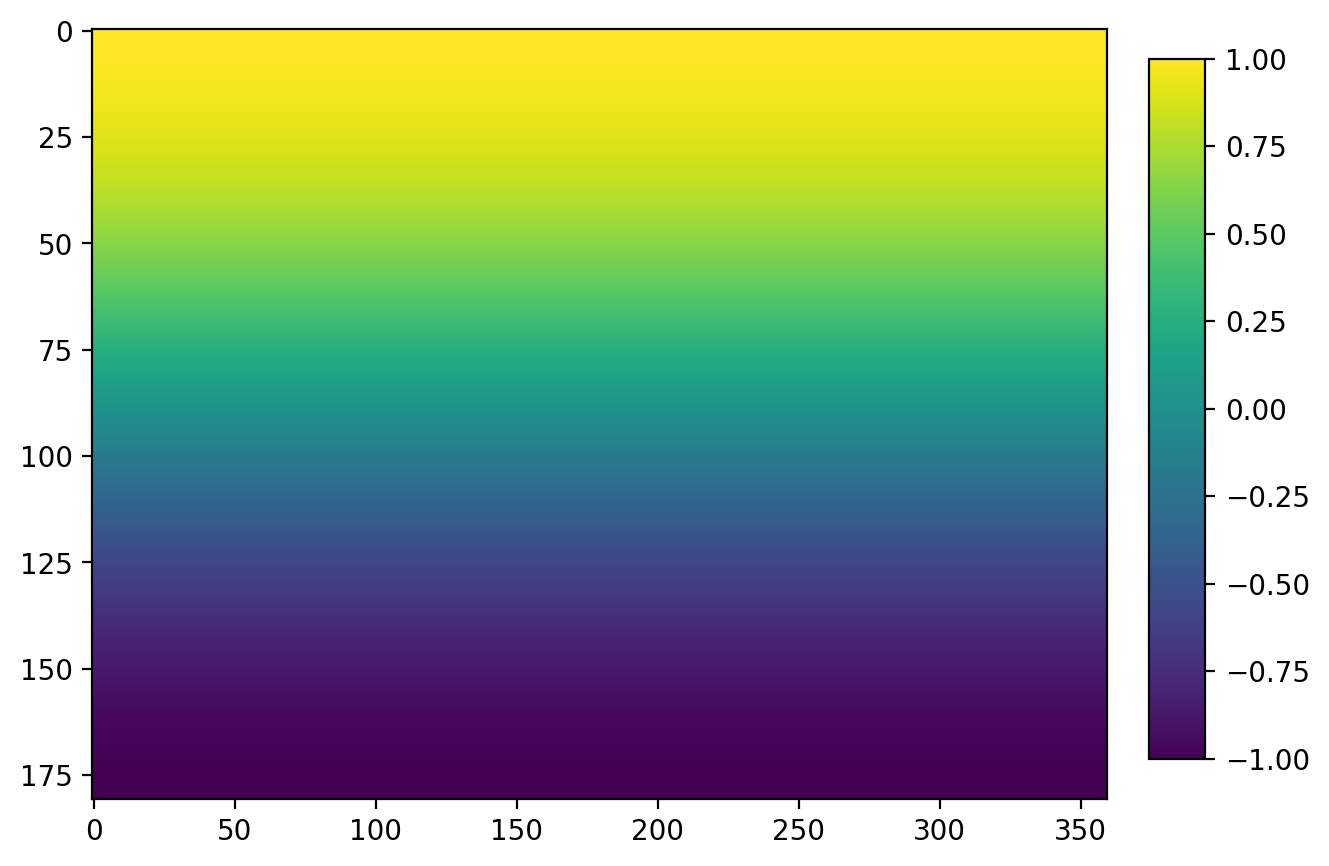

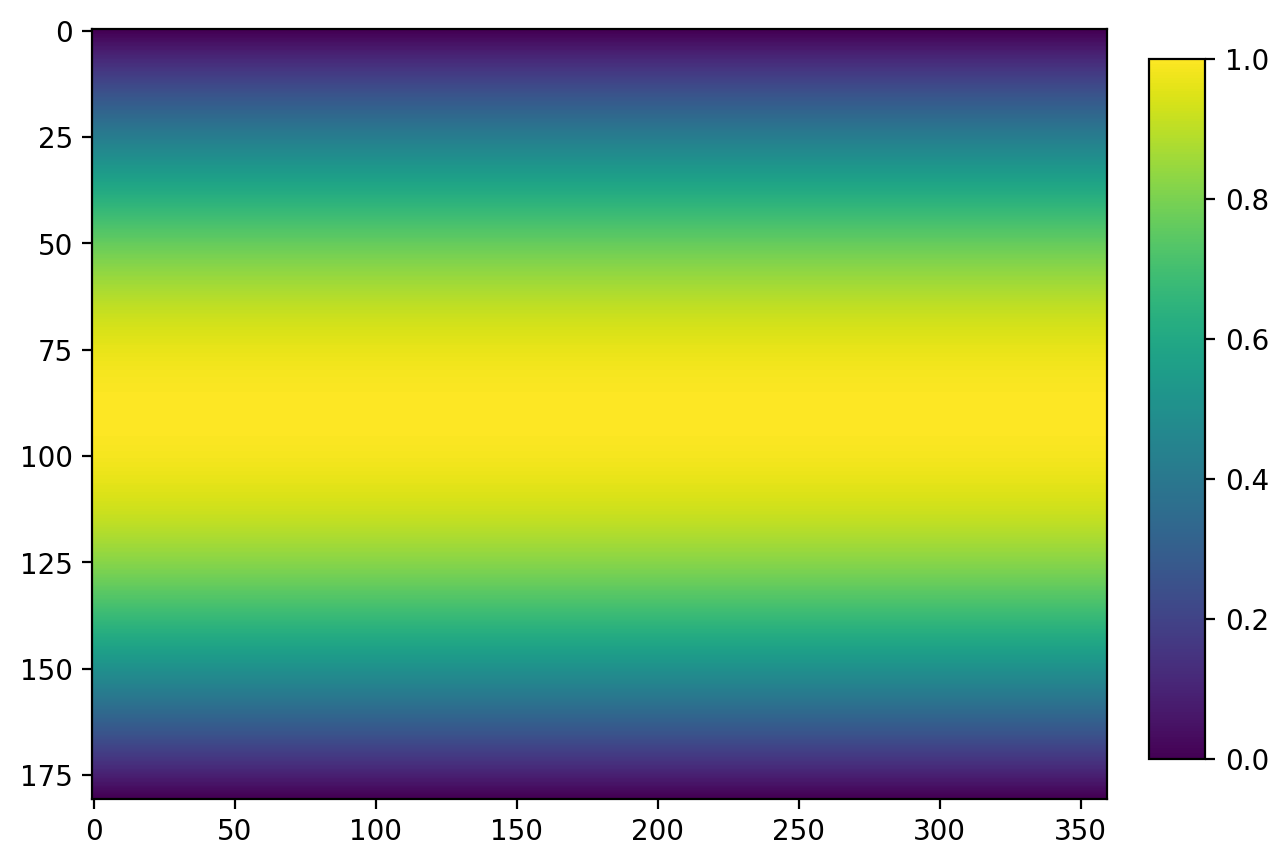

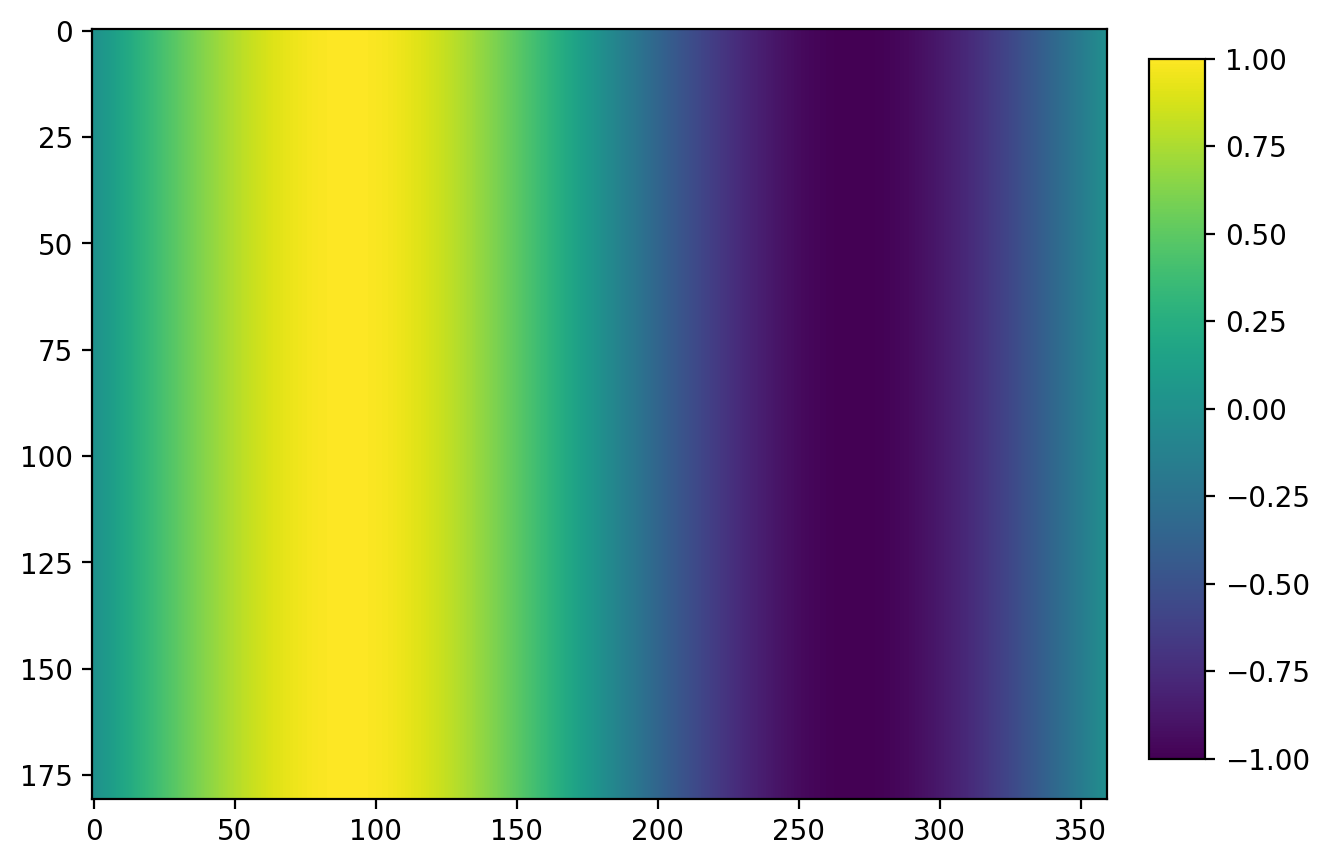

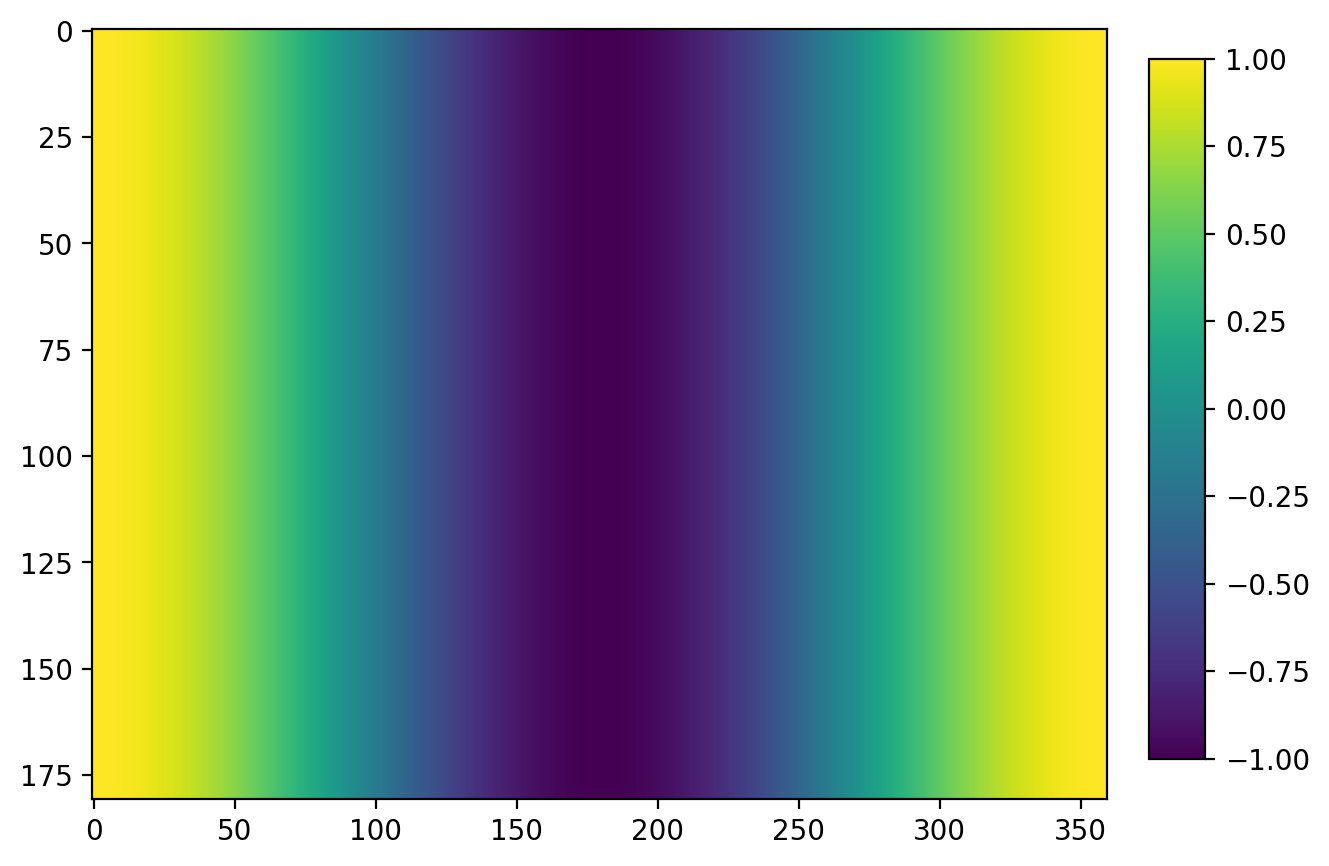

In [29]:
for i_batch, batch in enumerate(dl_test):
    # lsm, z_scal, sin/cos lat, sin/cos lon
    check_static_fields(batch.X)
    break

In [30]:
# load the constants, check against the batched values
ds_const = xr.load_dataset("/ec/res4/hpcperm/syma/WeatherBench/netcdf/constants.nc")
ds_const

<xarray.Dataset>
Dimensions:    (longitude: 360, latitude: 181)
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
Data variables: (12/15)
    dl         (latitude, longitude) float32 4.167e+03 4.167e+03 ... 25.0 25.0
    cl         (latitude, longitude) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tvl        (latitude, longitude) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    tvh        (latitude, longitude) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lai_lv     (latitude, longitude) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lai_hv     (latitude, longitude) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...         ...
    isor       (latitude, longitude) float32 0.0 0.0 0.0 ... 0.3503 0.3503
    anor       (latitude, longitude) float32 0.7854 0.7854 ... -1.249 -1.249
    slor       (latitude, longitude) float32 0.0001 0.0001 ... 0.002025 0.002025
    lsm        (latitude, longitude) float32 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    z_std      (latitude, longitude) float32 -0.448 -0.448 ... 2.848 2.848
    z_scal     (latitude, longitude) float32 -2.245e-05 -2.245e-05 ... 0.5019
Attributes:
    Conventions:  CF-1.6
    history:      2022-06-24 19:04:02 GMT by grib_to_netcdf-2.23.0: grib_to_n...

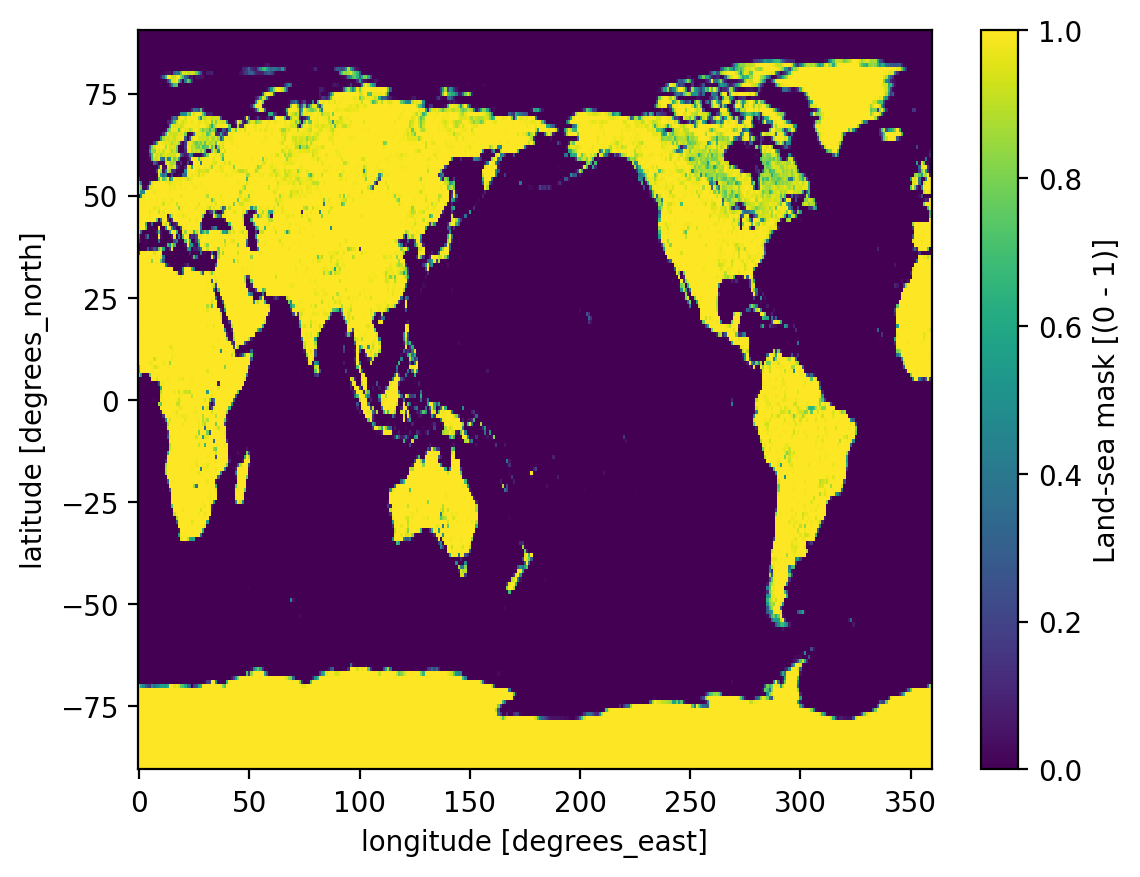

In [31]:
ds_const.lsm.plot();

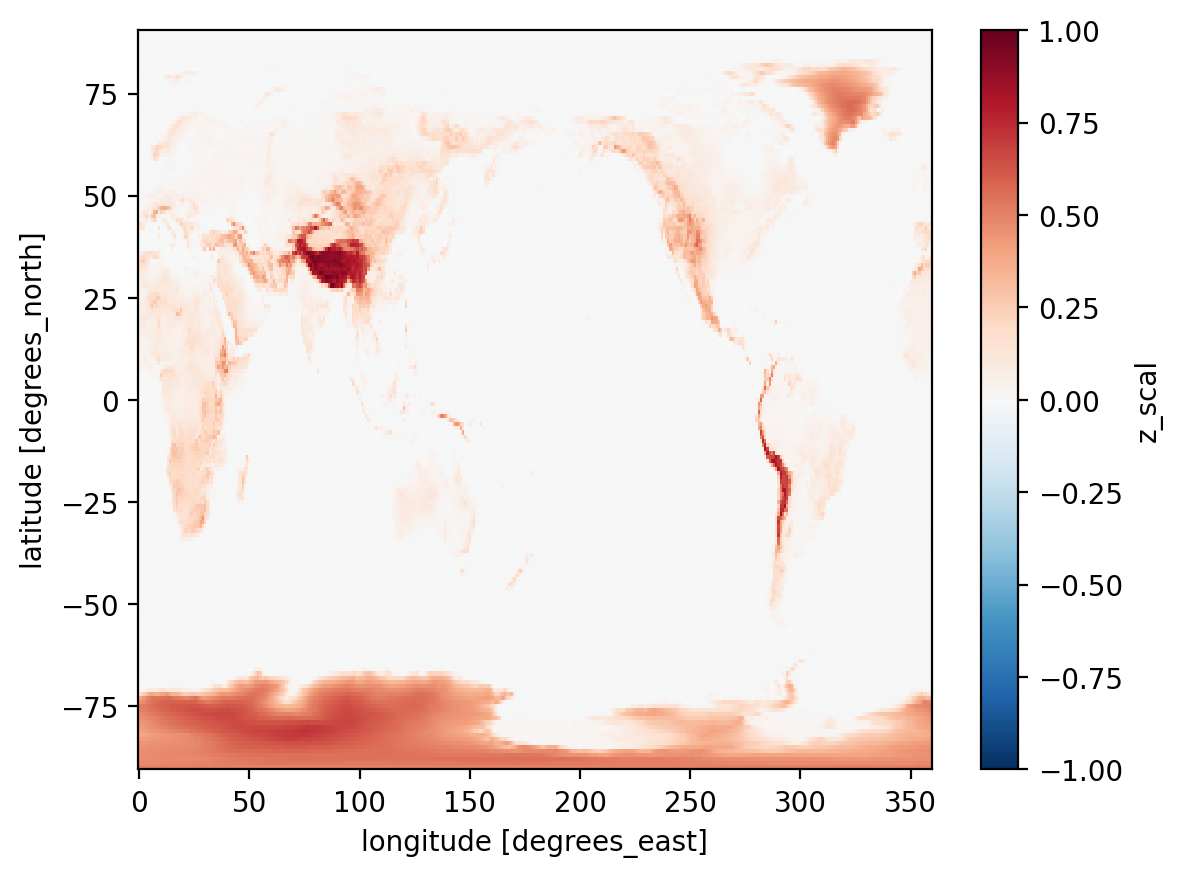

In [32]:
ds_const.z_scal.plot();